# Projet Traitement et Données Large Échelle

Zoé MARQUIS & Charlotte KRUZIC

## Exécution des scripts d'installation 

TODO : AJOUTER LE NOM DES FICHIERS BASH UNE FOIS QU'IlS SONT CORRECTS TODOSETUP

Nous avons initialement exploré la possibilité d'exécuter nos scripts sur Google Colab afin de faciliter l'exécution sans que vous ayez à configurer quoi que ce soit sur votre machine locale. Cependant, Colab présente certaines limitations, notamment l'incapacité de gérer plusieurs réplicas sets, car il ne permet de travailler qu'avec un seul environnement d'exécution.

Pour pouvoir simuler plusieurs réplicas sets dans notre projet, nous avons besoin de plusieurs nœuds, ce qui n'est pas possible sur Colab. Nous avons également essayé d'utiliser des solutions gratuites comme Datastax (ou une autre plateforme similaire), mais ces services ne permettaient pas de configurer correctement les réplicas sets, ce qui limitait la flexibilité nécessaire à notre projet.

En conséquence, nous avons opté pour une autre solution : créer des fichiers de configuration, comme cela est souvent demandé dans les exercices de type TP MongoDB. Cette approche permet de travailler de manière plus flexible tout en maintenant un contrôle total sur les paramètres des réplicas sets.

Une autre remarque importante : le projet a été testé avec Python 3.11, car Python 3.12 a introduit quelques incompatibilités qui ont causé des bugs. Il est donc recommandé d'utiliser Python 3.11 pour éviter ces problèmes.

Dans ce projet, nous avons initialement utilisé MySQL comme système de gestion de base de données en raison de ses fonctionnalités robustes et de sa capacité à gérer des volumes de données conséquents. Cependant, lorsque nous avons tenté d'intégrer MySQL à Google Colab, nous avons rencontré des problèmes majeurs.

### Problèmes avec MySQL sur Colab :  
- **Installation complexe** : Colab étant un environnement cloud éphémère, l'installation de MySQL nécessite des étapes supplémentaires pour télécharger et configurer le serveur MySQL à chaque exécution.  
- **Lancement du serveur** : MySQL nécessite un serveur en arrière-plan, ce qui n'est pas trivial à configurer dans l'environnement de Colab.
- **Limitations de Colab** : Colab n'est pas conçu pour maintenir un serveur de base de données actif sur le long terme. Cela a entraîné des arrêts inattendus et une perte de données temporaires entre les sessions.  
- **Connexion distante compliquée** : L'utilisation de MySQL dans un environnement distant comme Colab aurait nécessité une configuration complexe pour établir une connexion sécurisée à une base de données MySQL externe.

### Transition vers SQLite :
Pour contourner ces problèmes, nous avons décidé d'utiliser SQLite, qui s'est avéré être une solution plus simple et adaptée à nos besoins pour les raisons suivantes :

- **Sans serveur** : Contrairement à MySQL, SQLite n'a pas besoin d'un serveur en arrière-plan. Cela élimine les problèmes liés à la configuration et à la gestion du serveur dans Colab.
- **Compatibilité universelle** : SQLite est intégré à Python et compatible avec tous les systèmes d'exploitation. Cela nous a permis de garantir que notre projet fonctionnerait facilement sur différents environnements locaux ou dans le cloud.
- **Facilité d'utilisation** : Avec SQLite, nous avons pu créer, modifier et accéder à des bases de données directement à partir de fichiers. Cela a simplifié les tests et la portabilité de notre projet.
- **Performance suffisante pour notre cas d'usage** : Bien que SQLite soit moins performant que MySQL pour des bases de données volumineuses, il est parfaitement adapté aux projets à petite échelle ou à des fins de prototypage, comme le nôtre.


## Comparaison de Performances entre Systèmes Relationnels et NoSQL : Étude de Cas avec le Catalogue Netflix

Dans ce projet, nous comparons les performances entre un système de base de données relationnel (SQLite) et un système NoSQL (Cassandra), en utilisant le **catalogue Netflix** comme jeu de données.   
Ce dataset, disponible en Open Data, offre une structure réaliste et adaptée pour explorer les différences entre ces deux approches de gestion de données.   
L'objectif principal est d'évaluer les performances pour des opérations d'insertion, mise à jour et requêtes complexes, tout en analysant les spécificités du système NoSQL choisi.

### Jeu de données

Le jeu de données utilisé contient des informations sur les films et séries disponibles sur Netflix, avec les attributs suivants : 
- `show_id` : Identifiant unique pour chaque émission ou film. 
- `type` 
- `title`
- `director` 
- `cast`
- `country`
- `date_added` 
- `release_year` 
- `rating` 
- `duration` 
- `listed_in` 
- `description`

### Schéma de données

```sql
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
```


---

## Fonctionnement de Cassandra
Apache Cassandra est un système de gestion de bases de données NoSQL conçu pour gérer de grandes quantités de données réparties sur plusieurs serveurs tout en maintenant une haute disponibilité et une tolérance aux pannes. Contrairement aux bases de données relationnelles, Cassandra suit un modèle décentralisé, ce qui lui permet de scaler facilement et d'offrir une forte résilience.

### Modèle de données de Cassandra :

Le modèle de données de Cassandra repose sur quelques concepts clés qui diffèrent des systèmes relationnels traditionnels.

- **Keyspace** :  
Un Keyspace dans Cassandra est l'équivalent d'une base de données dans les systèmes relationnels. Il sert à regrouper des tables (ou Column Families) et définit la stratégie de réplication des données. Par exemple, il spécifie le nombre de répliques à conserver pour chaque donnée afin d'assurer une haute disponibilité et une tolérance aux pannes. La réplication des données dans Cassandra suit des stratégies comme "SimpleStrategy" (réplication sur tous les nœuds) ou "NetworkTopologyStrategy" (réplication sur des nœuds répartis sur plusieurs centres de données).
- **Column Family** :  
Une Column Family dans Cassandra est équivalente à une table relationnelle, mais avec une flexibilité plus grande. Chaque Column Family contient plusieurs colonnes, et contrairement aux bases de données relationnelles, les colonnes n'ont pas besoin d'être définies à l'avance. Elles peuvent être ajoutées dynamiquement au fil du temps, ce qui permet d'évoluer facilement sans migrations complexes.
- **Key (Clé primaire)** :  
Chaque ligne dans une Column Family est identifiée par une clé unique. Cette clé est utilisée pour partitionner et localiser les données efficacement. Elle peut être composée d'un seul champ (clé primaire simple) ou de plusieurs champs (clé primaire composée). Par exemple, dans une table contenant des films, une clé primaire pourrait être show_id (identifiant du film).
- **Colonnes** :  
Les données dans Cassandra sont stockées sous forme de colonnes. Chaque colonne a trois composants essentiels :
    - Nom : Le nom de la colonne (par exemple, title, release_year).
    - Valeur : La donnée proprement dite (par exemple, "Inception", "2010").
    - Timestamp : Le timestamp associé à la colonne, qui permet de gérer les versions des données et de résoudre les conflits de réplication, ce qui est essentiel dans un système distribué. Il permet de savoir quelle version d'une colonne est la plus récente.  
Ces colonnes sont indépendantes les unes des autres. Cela signifie qu'elles peuvent être insérées, mises à jour ou supprimées sans impacter les autres colonnes dans la même ligne.
- **Super Colonnes** :  
Les Super Colonnes sont une structure plus avancée dans Cassandra. Elles permettent de regrouper plusieurs colonnes sous un même nom de "super colonne". Cela permet de créer des structures hiérarchiques ou imbriquées dans les données, où une super colonne peut contenir plusieurs colonnes. Ce mécanisme est utile pour des cas complexes, mais il est désormais souvent moins utilisé au profit de modèles de données plus simples.

Source : 
- http://www-igm.univ-mlv.fr/~dr/XPOSE2010/Cassandra/modele.html

### Architecture de Cassandra :

L'architecture de Cassandra est décentralisée et repose sur un modèle peer-to-peer, ce qui signifie qu'il n'y a pas de nœud maître ou de coordination centralisée. Tous les nœuds sont égaux et partagent le même rôle. Cela permet une grande scalabilité et une tolérance aux pannes.

- Partitions et Réplication : Cassandra répartit les données entre différents nœuds via un mécanisme de partitionnement basé sur un hash de la clé primaire. Chaque nœud du cluster stocke une portion des données, et des répliques de ces données peuvent être présentes sur plusieurs nœuds, selon la stratégie de réplication définie dans le Keyspace. Cela permet à Cassandra d'assurer une haute disponibilité, même en cas de panne d'un ou plusieurs nœuds.
- Consistence et Quorum : Cassandra suit un modèle de consistance configurable, permettant de choisir entre des garanties de consistance fortes ou une consistance plus faible en fonction des besoins. Cela se configure via les paramètres Read Consistency Level et Write Consistency Level. Par exemple, un niveau de consistance QUORUM signifie qu'une opération de lecture ou d'écriture devra être validée par la majorité des répliques d'une donnée avant de réussir.

# TODO : ajouter une source

### Requêtes et Modèle de Consistance :

Les requêtes dans Cassandra utilisent le Cassandra Query Language (CQL), qui ressemble à SQL mais avec des différences significatives adaptées aux particularités du modèle NoSQL.

- Clé primaire et partitions : Dans Cassandra, la clé primaire détermine comment les données sont partitionnées et distribuées à travers les nœuds du cluster. Il est essentiel de bien concevoir cette clé pour assurer des performances optimales. La clé primaire peut être composée de :
    - Partition key : La clé utilisée pour déterminer la partition sur un nœud.
    - Clustering key : La clé qui permet de trier les données au sein d'une même partition.
- Sélection et filtrage : Cassandra fonctionne très bien pour les requêtes basées sur la clé primaire. Les requêtes qui filtrent sur d'autres colonnes nécessitent l'utilisation d'index secondaires ou d'une modélisation spécifique des données pour garantir de bonnes performances. Si vous tentez de filtrer sur une colonne sans index, vous recevrez une erreur ALLOW FILTERING, ce qui signifie que la requête pourrait être très coûteuse en termes de performance.

### Avantages et Inconvénients de Cassandra :

#### Avantages :
- Haute scalabilité horizontale (ajout facile de nœuds).
- Résilience et tolérance aux pannes grâce à la réplication des données.
- Facilité d'ajout de nouvelles colonnes sans affecter les données existantes.
#### Inconvénients :
- Consistance éventuelle : Cassandra privilégie la disponibilité et la partitionnement des données, parfois au détriment de la consistance immédiate.
- Pas de support pour les jointures, les transactions complexes ou les relations entre tables, ce qui oblige à repenser la manière de modéliser les données. Ceci est le cas pour toutes les bases de données NoSQL.

### Conclusion :
Cassandra est une base de données extrêmement puissante pour les cas d'utilisation à grande échelle et hautement distribués, avec une grande tolérance aux pannes. Cependant, sa conception impose certaines contraintes sur la manière de structurer les données, et une bonne compréhension de son modèle de partitionnement est essentielle pour garantir de bonnes performances. Les applications qui nécessitent des requêtes complexes et des jointures devront probablement repenser leur modèle de données ou utiliser des outils supplémentaires pour effectuer des analyses en dehors de Cassandra.

## Fonctionnement de SQLite
SQLite est une base de données relationnelle légère, autonome et sans serveur, idéale pour les applications qui nécessitent une gestion locale des données sans nécessiter de serveur de base de données externe. Voici les principaux points qui caractérisent son fonctionnement :

- Base de données embarquée : Contrairement aux systèmes de gestion de base de données classiques (comme MySQL ou PostgreSQL), SQLite est une base de données embarquée, ce qui signifie qu'elle est directement intégrée dans l'application sans nécessiter de processus serveur séparé. Toutes les données sont stockées dans un fichier unique sur le disque.
- Structure relationnelle : SQLite suit le modèle relationnel classique, avec des tables, des colonnes et des lignes. Il prend en charge les requêtes SQL classiques (SELECT, INSERT, UPDATE, DELETE), et permet la gestion des contraintes, des index et des transactions ACID (Atomicité, Cohérence, Isolation, Durabilité).
- Pas de gestion de serveur : SQLite ne nécessite pas d'installation de serveur ni de configuration complexe, ce qui simplifie grandement son utilisation pour des applications légères, des prototypes ou des applications mobiles. Cela permet également une gestion plus simple des données localement, sans besoin de se soucier de la gestion d'un serveur distant.
- Performance : Bien que très performant pour des opérations locales et des volumes de données modestes, SQLite n'est pas conçu pour les applications à grande échelle nécessitant une scalabilité horizontale ou une haute disponibilité. C'est une excellente solution pour des applications mononucléaires ou pour des projets qui ne nécessitent pas de réplication de données.
- Transactions ACID : SQLite assure l'intégrité des données grâce à son modèle transactionnel, ce qui garantit que les opérations sont atomiques et cohérentes. Cependant, sa gestion des transactions simultanées est moins robuste que dans des systèmes plus avancés comme PostgreSQL ou Cassandra.

### Avantages 

##### Efficacité en mémoire
SQLite se distingue par son faible besoin en mémoire. Avec seulement quelques centaines de kilooctets, la bibliothèque occupe un espace minimal, ce qui améliore naturellement la rapidité du système. Ce faible encombrement en fait une solution idéale pour des applications de toutes tailles, des plus simples aux plus complexes.

##### Autonomie
SQLite fonctionne sans nécessiter de logiciel serveur supplémentaire. Il s’intègre facilement, sans dépendances externes ou configurations complexes. Cela simplifie son utilisation tout en éliminant la charge de gestion d’un serveur.

##### Polyvalence
En plus de supporter la majorité des commandes SQL standard, SQLite est compatible avec de nombreux formats de données. Cette flexibilité a conduit à son adoption dans des applications majeures telles que Facebook et WhatsApp, ainsi que dans divers systèmes d’exploitation, navigateurs et outils professionnels. Sa capacité à permettre un échange fluide entre différents systèmes en fait un choix privilégié pour de nombreux développeurs.

##### Portabilité
Les fichiers SQLite sont faciles à sauvegarder et à transférer. Comme ils ne dépendent pas d’un serveur ou d’une configuration complexe, ils peuvent être utilisés sans problème sur des plateformes variées.

##### Fiabilité
Avec un accès aux données unifié, une faible consommation de ressources et une indépendance vis-à-vis de l’architecture serveur-client, SQLite est une option fiable. Les erreurs de mémoire ou les limitations dues à un manque de RAM y sont également moins fréquentes.

##### Libre de droits
SQLite est disponible en domaine public, sans licence. Seuls certains modules complémentaires et le support sont payants, ce qui en fait une solution économique.

### Limites de SQLite

##### Absence de gestion multi-utilisateurs
SQLite ne permet pas de gérer plusieurs comptes utilisateurs ou connexions simultanées. Contrairement à d’autres bases de données, il n’est pas conçu pour supporter une architecture multi-clients.

##### Impact de la croissance des données
Bien que léger, SQLite voit ses besoins en espace augmenter proportionnellement à la taille de la base de données. Cela peut avoir un effet négatif sur les performances lorsqu’il s’agit de gérer des volumes importants de données.

##### Limitation en flexibilité pour les requêtes client
En raison de son indépendance vis-à-vis des serveurs externes, SQLite ne prend pas en charge les requêtes de données effectuées directement par un client. De plus, il ne gère pas les connexions multiples simultanément, ce qui peut entraîner des retards dans certaines applications.

Source : https://www.ionos.fr/digitalguide/sites-internet/developpement-web/sqlite/#:~:text=En%20tant%20que%20système%20de,sont%20utilisées%20à%20cet%20effet.

---
## Installer les outils

In [ ]:
# TODO : Faire un fichier de requirement pour ca plutot non ? TODOSETUP

In [3]:
!pip install plotly 

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install pandas
# pour manipuler des dataframes et charger les données de kaggle

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install cassandra-driver

Defaulting to user installation because normal site-packages is not writeable
  Using cached geomet-0.2.1.post1-py3-none-any.whl.metadata (1.0 kB)
Using cached geomet-0.2.1.post1-py3-none-any.whl (18 kB)


In [7]:
# TODO à vérifier sur ubuntu et mac e fonctoin de comment on a fait les scripts d'installation
# # 🚨 sur linux 
# !apt-get update
# !apt-get install -y openjdk-11-jdk
# !apt-get install libev-dev
# !apt-get install cassandra

# # 🚨 sur mac
# !brew install openjdk@17
# !brew install libev
# !brew install cassandra


In [8]:
!pip install kagglehub
# installer kagglehub pour récupérer le dataset

Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [9]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [ ]:
# importer toutes les librairies nécessaires
from cassandra.cluster import Cluster

import kagglehub

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random

import sqlite3

from tabulate import tabulate
import time

## Importation des données

In [ ]:
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Chemin vers le fichier du dataset : ", path)

/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chemin vers le fichier du dataset :  /Users/zoemarquis/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [ ]:
files = os.listdir(path)
print("Nom du fichier : ", files)

Nom du fichier :  ['netflix_titles.csv']


In [ ]:
filename = f"{path}/{files[0]}"
df_initial = pd.read_csv(filename)

In [ ]:
print(tabulate(df_initial.head(10), headers='keys', tablefmt='psql'))

+----+-----------+---------+----------------------------------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+--------------------+----------------+----------+------------+---------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | show_id   | type    | title                            | director                      | cast                                                                                                                                                

In [15]:
# afficher le nombre de lignes dans le dataset
print(f"Nombre de lignes : {len(df_initial)}")

Nombre de lignes : 8807


In [16]:
# types des colonnes
print(df_initial.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [17]:
# Convertir la colonne show_id en int en enlevant le préfixe 's' (plus simple pour gérer exactement le meme type de données en Cassandra et MySQL)
df_initial['show_id'] = df_initial['show_id'].str.replace('s', '').astype(int).astype(int)

df_initial['show_id'] = df_initial['show_id'].astype(int)
df_initial['release_year'] = df_initial['release_year'].astype(int)

df_initial['type'] = df_initial['title'].astype(str)
df_initial['title'] = df_initial['title'].astype(str)
df_initial['director'] = df_initial['director'].astype(str)
df_initial['cast'] = df_initial['cast'].astype(str)
df_initial['country'] = df_initial['country'].astype(str)
df_initial['date_added'] = df_initial['date_added'].astype(str)
df_initial['rating'] = df_initial['rating'].astype(str)
df_initial['duration'] = df_initial['duration'].astype(str)
df_initial['listed_in'] = df_initial['listed_in'].astype(str)
df_initial['description'] = df_initial['description'].astype(str)

In [18]:
# types des colonnes
print(df_initial.dtypes)

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


## CRUD : Create, Read, Update, Delete
- Create (*Insert*) : Insérer des données dans la base de données.
- Read (*Select*) : Récupérer des données.
- Update (*Update*) : Modifier des données existantes.
- Delete (*Delete*) : Effacer des données.

In [19]:
schema = """
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
"""

In [20]:
data_zoe_charlotte = {
    'show_id': [0],
    'title': ['Zoé & Charlotte'],
    'type': ['Movie'],
    'director': ['Christopher Nolan'],
    'cast': ['Leonardo DiCaprio, Joseph Gordon-Levitt'],
    'country': ['USA'],
    'date_added': ['2021-01-01'],
    'release_year': [2001],
    'rating': ['PG-13'],
    'duration': ['148 min'],
    'listed_in': ['Action, Sci-Fi'],
    'description': ['A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a CEO.']
}
df_zoe_charlotte = pd.DataFrame(data_zoe_charlotte)

### SQLite

In [ ]:
# Créer une base de données SQLite en mémoire
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def drop_table_sqlite():
    cursor.execute("DROP TABLE IF EXISTS shows;")
    conn.commit()

def create_table_sqlite():
    # Crée ta table ici
    cursor.execute(schema)
    conn.commit()

drop_table_sqlite()
create_table_sqlite()


In [ ]:
# --- CREATE ---
def sqlite_insert(df):
    drop_table_sqlite()
    create_table_sqlite()
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    return create_time_sqlite

# --- READ ---
def sqlite_read(df):
    # drop_table_sqlite()
    # create_table_sqlite()
    sqlite_insert(df)
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year > 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    return read_time_sqlite

# --- UPDATE ---
def sqlite_update(df):
    # drop_table_sqlite()
    # create_table_sqlite()
    sqlite_insert(df)
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year > 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    return update_time_sqlite

# --- DELETE ---
def sqlite_delete(df):
    # drop_table_sqlite()
    # create_table_sqlite()
    sqlite_insert(df)
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year > 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    return delete_time_sqlite

In [ ]:
# Fonction pour effectuer une opération plusieurs fois et calculer la moyenne et l'écart-type
def benchmark_operation(func, *args):
    times = []
    for _ in range(5):  # Effectuer 5 itérations
        times.append(func(*args))  # Exécuter la fonction avec les arguments
    
    # Calculer la moyenne et l'écart-type
    mean_time = np.mean(times)
    std_time = np.std(times)
    return mean_time, std_time

# --- CREATE ---
create_sqlite_mean, create_sqlite_std = benchmark_operation(sqlite_insert, df_zoe_charlotte)
print(f"CREATE: Mean Time = {create_sqlite_mean:.6f}s, Std Time = {create_sqlite_std:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_sqlite_mean, read_sqlite_std = benchmark_operation(sqlite_read, df_zoe_charlotte)
print(f"READ: Mean Time = {read_sqlite_mean:.6f}s, Std Time = {read_sqlite_std:.6f}s")

# --- UPDATE ---
update_sqlite_mean, update_sqlite_std = benchmark_operation(sqlite_update, df_zoe_charlotte)
print(f"UPDATE: Mean Time = {update_sqlite_mean:.6f}s, Std Time = {update_sqlite_std:.6f}s")

# --- DELETE ---
delete_sqlite_mean, delete_sqlite_std = benchmark_operation(sqlite_delete, df_zoe_charlotte)
print(f"DELETE: Mean Time = {delete_sqlite_mean:.6f}s, Std Time = {delete_sqlite_std:.6f}s")

Create Time: 0.000265 seconds
Create Time: 0.000104 seconds
Create Time: 0.000059 seconds
Create Time: 0.000047 seconds
Create Time: 0.000108 seconds
CREATE: Mean Time = 0.000116s, Std Time = 0.000078s
Total rows in 'shows' table: 1
Create Time: 0.000068 seconds
Read Time: 0.000015 seconds
Queried 1 records
Create Time: 0.000069 seconds
Read Time: 0.000010 seconds
Queried 1 records
Create Time: 0.000051 seconds
Read Time: 0.000007 seconds
Queried 1 records
Create Time: 0.000044 seconds
Read Time: 0.000007 seconds
Queried 1 records
Create Time: 0.000041 seconds
Read Time: 0.000007 seconds
Queried 1 records
READ: Mean Time = 0.000009s, Std Time = 0.000003s
Create Time: 0.000047 seconds
Update Time: 0.000008 seconds
Create Time: 0.000043 seconds
Update Time: 0.000006 seconds
Create Time: 0.000042 seconds
Update Time: 0.000005 seconds
Create Time: 0.000039 seconds
Update Time: 0.000005 seconds
Create Time: 0.000039 seconds
Update Time: 0.000005 seconds
UPDATE: Mean Time = 0.000006s, Std Ti

##### Test d'insertion avec une ligne de DataFrame
Nous avons d'abord testé l'insertion d'une seule ligne de données extraite d'un DataFrame dans notre base de données. Cette étape permet de vérifier que l'insertion fonctionne correctement sur un cas simple, avant de passer à l'insertion de l'ensemble du DataFrame.

À ce stade, l'insertion a été réalisée avec succès sur une ligne de données, ce qui nous permet d'assurer que la logique de base est correcte. Nous allons maintenant procéder à l'insertion du DataFrame complet pour tester la gestion de plusieurs lignes et évaluer les performances d'insertion à plus grande échelle.

In [24]:
# --- CREATE ---
create_sqlite_massive_mean, create_sqlite_massive_std = benchmark_operation(sqlite_insert, df_initial)
print(f"CREATE: Mean Time = {create_sqlite_massive_mean:.6f}s, Std Time = {create_sqlite_massive_std:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_sqlite_massive_mean, read_sqlite_massive_std = benchmark_operation(sqlite_read, df_initial)
print(f"READ: Mean Time = {read_sqlite_massive_mean:.6f}s, Std Time = {read_sqlite_massive_std:.6f}s")

# --- UPDATE ---
update_sqlite_massive_mean, update_sqlite_massive_std = benchmark_operation(sqlite_update, df_initial)
print(f"UPDATE: Mean Time = {update_sqlite_massive_mean:.6f}s, Std Time = {update_sqlite_massive_std:.6f}s")

# --- DELETE ---
delete_sqlite_massive_mean, delete_sqlite_massive_std = benchmark_operation(sqlite_delete, df_initial)
print(f"DELETE: Mean Time = {delete_sqlite_massive_mean:.6f}s, Std Time = {delete_sqlite_massive_std:.6f}s")

Create Time: 0.135467 seconds
Create Time: 0.133374 seconds
Create Time: 0.135358 seconds
Create Time: 0.130738 seconds
Create Time: 0.130784 seconds
CREATE: Mean Time = 0.133144s, Std Time = 0.002084s
Total rows in 'shows' table: 8807
Create Time: 0.128457 seconds
Read Time: 0.008031 seconds
Queried 8245 records
Create Time: 0.132015 seconds
Read Time: 0.007477 seconds
Queried 8245 records
Create Time: 0.132552 seconds
Read Time: 0.007437 seconds
Queried 8245 records
Create Time: 0.133280 seconds
Read Time: 0.007423 seconds
Queried 8245 records
Create Time: 0.133945 seconds
Read Time: 0.007420 seconds
Queried 8245 records
READ: Mean Time = 0.007558s, Std Time = 0.000238s
Create Time: 0.129571 seconds
Update Time: 0.003300 seconds
Create Time: 0.130176 seconds
Update Time: 0.003029 seconds
Create Time: 0.131350 seconds
Update Time: 0.003651 seconds
Create Time: 0.135176 seconds
Update Time: 0.003276 seconds
Create Time: 0.131597 seconds
Update Time: 0.003195 seconds
UPDATE: Mean Time =

### Cassandra

In [25]:
# vérifier l'état actuel du noeud Cassandra
!nodetool status

Datacenter: datacenter1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address    Load        Tokens  Owns (effective)  Host ID                               Rack 
UN  127.0.0.1  860,64 KiB  16      100,0%            11c2e131-3642-40ab-a44b-5d5e95f42edb  rack1



In [ ]:
# Connexion à Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


def drop_table_cassandra():
    session.execute("""
        DROP TABLE IF EXISTS netflix.shows;
        """)
    session.execute("""
        DROP KEYSPACE IF EXISTS netflix;
        """)

def create_table_cassandra(replication_factor):
    session.execute(f"""
        CREATE KEYSPACE netflix
        WITH REPLICATION = {{
            'class': 'SimpleStrategy', 
            'replication_factor': {replication_factor}
        }};
        """)
    session.set_keyspace('netflix')
    session.execute(schema)
    print(f"replication factor = {replication_factor}")

     
drop_table_cassandra()
create_table_cassandra(1)

replication factor = 1


##### Test sans index
Pour l'instant, nous effectuons les tests sans index. Cette approche nous permettra d'évaluer les performances de base. Nous ajouterons ensuite des index pour comparer les résultats et analyser l'impact sur les performances des requêtes.

In [27]:
# --- CREATE ---
def cassandra_insert(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time

    print(f"Create Time: {create_time:.6f} seconds")

    return create_time

# --- READ ---
def cassandra_read(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    # drop_table_cassandra()
    # create_table_cassandra(nb_repl)
    cassandra_insert(df, nb_repl)

    start_time = time.time()
    # On utilise ici ALLOW FILTERING car release_year ne fait pas partie de la clef primaire
    result = session.execute("SELECT * FROM shows WHERE release_year > 2000 ALLOW FILTERING")
    read_time = time.time() - start_time
    print(f"Read Time: {read_time:.6f} seconds")
    num_records = sum(1 for _ in result)  # Count rows using a generator expression
    print(f"Queried {num_records} records")
    return read_time

# --- UPDATE ---
def cassandra_update(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    # drop_table_cassandra()
    # create_table_cassandra(nb_repl)
    cassandra_insert(df, nb_repl)

    # On doit faire select et update car realease_year ne fait pas partie de la clef primaire
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year > 2000 ALLOW FILTERING;"
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]

    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)

    update_time = time.time() - start_time
    print(f"Update Time: {update_time:.6f} seconds")
    return update_time

# --- DELETE ---
def cassandra_delete(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    # drop_table_cassandra()
    # create_table_cassandra(nb_repl)
    cassandra_insert(df, nb_repl)
    
    # Comme pour update
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year > 2000 ALLOW FILTERING;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]

    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)

    delete_time = time.time() - start_time
    print(f"Delete Time: {delete_time:.6f} seconds")
    return delete_time

In [28]:
# --- CREATE ---
create_cassandra_mean, create_cassandra_std = benchmark_operation(cassandra_insert, df_zoe_charlotte, 1)
print(f"CREATE: Mean Time = {create_cassandra_mean:.6f}s, Std Time = {create_cassandra_std:.6f}s")

# Vérifier le nombre de lignes insérées
result = session.execute('SELECT COUNT(*) FROM shows')
row = result.one()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_mean, read_cassandra_std = benchmark_operation(cassandra_read, df_zoe_charlotte, 1)
print(f"READ: Mean Time = {read_cassandra_mean:.6f}s, Std Time = {read_cassandra_std:.6f}s")

# --- UPDATE ---
update_cassandra_mean, update_cassandra_std = benchmark_operation(cassandra_update, df_zoe_charlotte, 1)
print(f"UPDATE: Mean Time = {update_cassandra_mean:.6f}s, Std Time = {update_cassandra_std:.6f}s")

# --- DELETE ---
delete_cassandra_mean, delete_cassandra_std = benchmark_operation(cassandra_delete, df_zoe_charlotte, 1)
print(f"DELETE: Mean Time = {delete_cassandra_mean:.6f}s, Std Time = {delete_cassandra_std:.6f}s")

replication factor = 1
Create Time: 0.002270 seconds
replication factor = 1
Create Time: 0.001254 seconds
replication factor = 1
Create Time: 0.001450 seconds
replication factor = 1
Create Time: 0.001923 seconds
replication factor = 1
Create Time: 0.001859 seconds
CREATE: Mean Time = 0.001751s, Std Time = 0.000360s
Total rows in 'shows' table: 1
replication factor = 1
Create Time: 0.001418 seconds
Read Time: 0.001379 seconds
Queried 1 records
replication factor = 1
Create Time: 0.001428 seconds
Read Time: 0.001184 seconds
Queried 1 records
replication factor = 1
Create Time: 0.001199 seconds
Read Time: 0.000971 seconds
Queried 1 records
replication factor = 1
Create Time: 0.001386 seconds
Read Time: 0.001166 seconds
Queried 1 records
replication factor = 1
Create Time: 0.001710 seconds
Read Time: 0.001613 seconds
Queried 1 records
READ: Mean Time = 0.001263s, Std Time = 0.000218s
replication factor = 1
Create Time: 0.001597 seconds
Update Time: 0.001484 seconds
replication factor = 1
C

In [29]:
# --- CREATE ---
create_cassandra_massive_mean, create_cassandra_massive_std = benchmark_operation(cassandra_insert, df_initial, 1)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean:.6f}s, Std Time = {create_cassandra_massive_std:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_massive_mean, read_cassandra_massive_std = benchmark_operation(cassandra_read, df_initial, 1)
print(f"READ: Mean Time = {read_cassandra_massive_mean:.6f}s, Std Time = {read_cassandra_massive_std:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean, update_cassandra_massive_std = benchmark_operation(cassandra_update, df_initial, 1)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean:.6f}s, Std Time = {update_cassandra_massive_std:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean, delete_cassandra_massive_std = benchmark_operation(cassandra_delete, df_initial, 1)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean:.6f}s, Std Time = {delete_cassandra_massive_std:.6f}s")

replication factor = 1
Create Time: 1.997576 seconds
replication factor = 1
Create Time: 1.971562 seconds
replication factor = 1
Create Time: 1.987478 seconds
replication factor = 1
Create Time: 1.976180 seconds
replication factor = 1
Create Time: 1.960307 seconds
CREATE: Mean Time = 1.978621s, Std Time = 0.012876s
Total rows in 'shows' table: 562
replication factor = 1
Create Time: 1.956140 seconds
Read Time: 0.056888 seconds
Queried 8245 records
replication factor = 1
Create Time: 1.968977 seconds
Read Time: 0.073621 seconds
Queried 8245 records
replication factor = 1
Create Time: 1.983601 seconds
Read Time: 0.056503 seconds
Queried 8245 records
replication factor = 1
Create Time: 1.960982 seconds
Read Time: 0.073753 seconds
Queried 8245 records
replication factor = 1
Create Time: 1.970628 seconds
Read Time: 0.056138 seconds
Queried 8245 records
READ: Mean Time = 0.063381s, Std Time = 0.008419s
replication factor = 1
Create Time: 1.959283 seconds
Update Time: 1.521791 seconds
replica

### Visualisation
Nous avons d'abord testé avec un seul replicaSet et sans index, en insérant une seule ligne de données pour simplifier les tests.

Ensuite, pour obtenir des statistiques plus réalistes, nous avons effectué des opérations CRUD sur un volume de données plus important, en utilisant les données de Kaggle précédemment chargées. 

Chaque action (insertion, lecture, mise à jour, suppression) a été réalisée cinq fois, et nous avons calculé la moyenne et l'écart-type pour chaque opération afin d'effectuer un benchmarking précis.

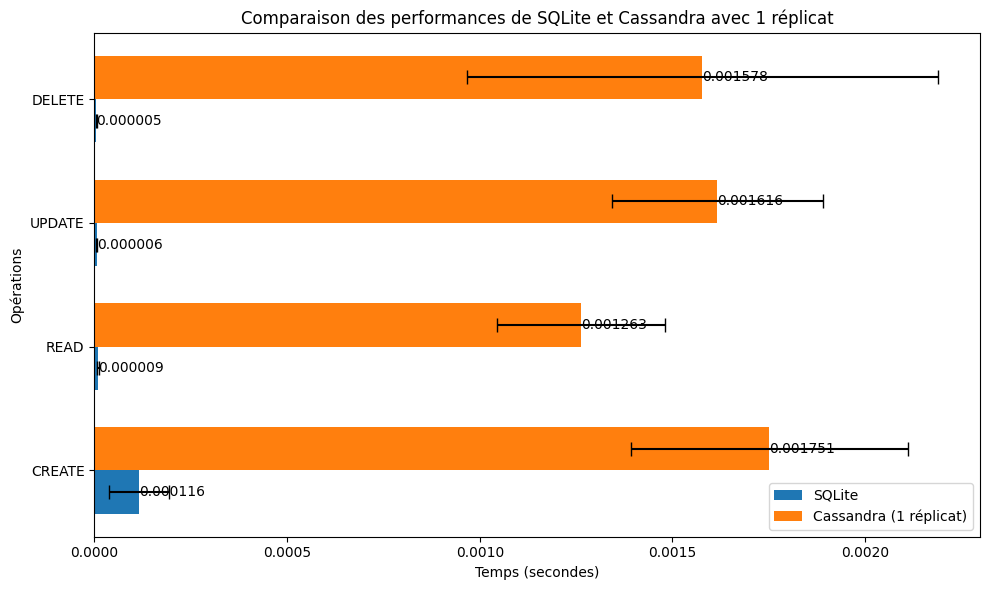

In [ ]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_mean, create_sqlite_std),
    'READ': (read_sqlite_mean, read_sqlite_std),
    'UPDATE': (update_sqlite_mean, update_sqlite_std),
    'DELETE': (delete_sqlite_mean, delete_sqlite_std)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cassandra_mean, create_cassandra_std),
    'READ': (read_cassandra_mean, read_cassandra_std),
    'UPDATE': (update_cassandra_mean, update_cassandra_std),
    'DELETE': (delete_cassandra_mean, delete_cassandra_std)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5)
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5)

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()


En testant SQLite et Cassandra avec une seule ligne de données et une réplication pour Cassandra, on remarque des différences claires :
 
- SQLite :  
Ici, l'opération la plus lente est la création de la ligne de données. En revanche, les lectures, mises à jour et suppressions sont rapides, ce qui montre que SQLite est bien optimisé pour des petits volumes de données.  
- Cassandra :  
La lecture est l'opération la plus rapide, ce qui correspond bien à la manière dont Cassandra est conçu pour gérer les requêtes en lecture.  
Les mises à jour et suppressions prennent à peu près le même temps, et sont un peu plus rapides que la création.  
La création, par contre, est la plus lente, probablement à cause de la gestion de la réplication et des contraintes liées à son architecture distribuée.    

Globalement, avec une seule ligne de données, Cassandra est beaucoup plus lent que SQLite. Cela s’explique par son architecture distribuée, qui ajoute un overhead même dans des contextes simples, et par ses mécanismes de réplication et de gestion des partitions, conçus pour des scénarios à grande échelle. En revanche, SQLite, étant une solution locale et légère, est optimisé pour des opérations rapides sur de petites bases de données.


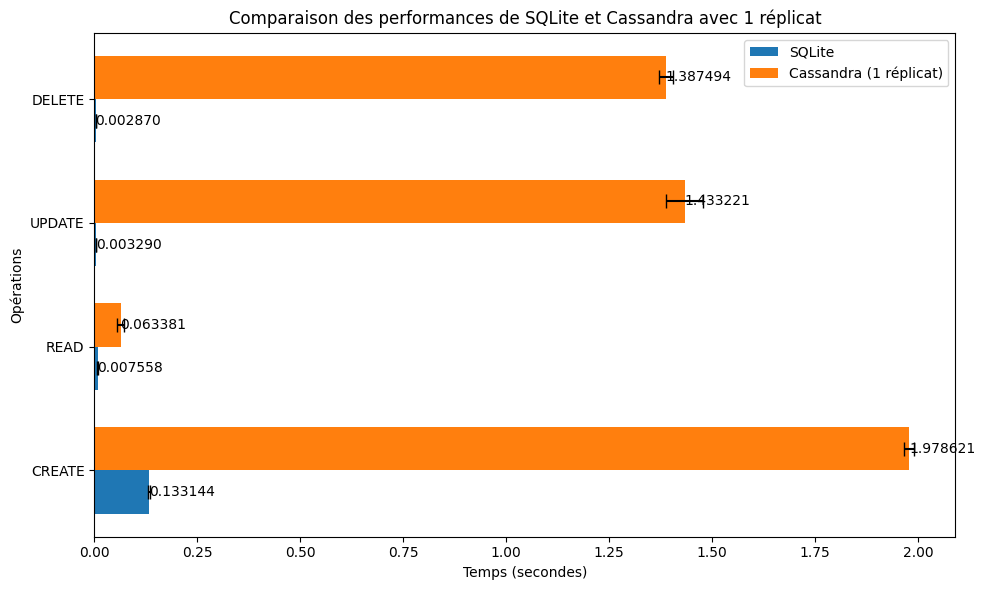

In [31]:
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean, create_sqlite_massive_std),
    'READ': (read_sqlite_massive_mean, read_sqlite_massive_std),
    'UPDATE': (update_sqlite_massive_mean, update_sqlite_massive_std),
    'DELETE': (delete_sqlite_massive_mean, delete_sqlite_massive_std)
}

cassandra_times = {
    'CREATE': (create_cassandra_massive_mean, create_cassandra_massive_std),
    'READ': (read_cassandra_massive_mean, read_cassandra_massive_std),
    'UPDATE': (update_cassandra_massive_mean, update_cassandra_massive_std),
    'DELETE': (delete_cassandra_massive_mean, delete_cassandra_massive_std)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5)
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5)

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()

Sur un volume de données beaucoup plus important, avec toujours un seul réplicat, la requête de création (CREATE) reste la plus longue pour SQLite comme pour Cassandra.

En Cassandra, les requêtes de lecture (READ) sont particulièrement rapides par rapport aux autres types de requêtes. Cela s'explique par la structure optimisée de Cassandra pour des lectures rapides, grâce à son indexation basée sur les partitions et l'utilisation de SSTables.

En revanche, les requêtes de suppression (DELETE) et de mise à jour (UPDATE) sont globalement plus longues et prennent un temps similaire en Cassandra, en raison des mécanismes internes de gestion des tombstones et de la propagation des modifications.

Enfin, même sur un grand volume de données, Cassandra reste globalement bien plus lent que SQLite, reflétant la différence entre une architecture distribuée conçue pour des données massives et une solution locale optimisée pour des bases de données plus légères.

Idées de pourquoi Cassandra reste plus lent : 
- Cassandra distribué : Optimisé pour des bases massives, mais sa gestion des partitions et des nœuds ajoute un coût, même sur une petite base.
- Replication : Même avec un seul réplicat, Cassandra gère la synchronisation, ce qui ralentit les écritures.
- Caching : SQLite utilise la mémoire locale efficacement, tandis que Cassandra coordonne entre nœuds, ce qui prend plus de temps.

## Comparaison des temps de Cassandra avec plusieurs replicaSet

##### Qu'est ce que *SimpleStrategy* ?
Description : Réplique les données de manière linéaire sur les n nœuds du cluster, où n est le replication_factor.
- Avantages :
    - Simple à configurer.
    - Adapté aux environnements de test ou aux clusters d'une seule région.
- Inconvénients :
    - Pas optimisé pour les déploiements multi-régions.
    - Répartition des réplicas pas toujours équilibrée en cas de cluster complexe.

In [32]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_2, create_cassandra_massive_std_2 = benchmark_operation(cassandra_insert, df_initial, 2)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean_2:.6f}s, Std Time = {create_cassandra_massive_std_2:.6f}s")

# --- READ ---
read_cassandra_massive_mean_2, read_cassandra_massive_std_2 = benchmark_operation(cassandra_read, df_initial, 2)
print(f"READ: Mean Time = {read_cassandra_massive_mean_2:.6f}s, Std Time = {read_cassandra_massive_std_2:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean_2, update_cassandra_massive_std_2 = benchmark_operation(cassandra_update, df_initial, 2)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_2:.6f}s, Std Time = {update_cassandra_massive_std_2:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean_2, delete_cassandra_massive_std_2 = benchmark_operation(cassandra_delete, df_initial, 2)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_2:.6f}s, Std Time = {delete_cassandra_massive_std_2:.6f}s")

replication factor = 2
Create Time: 2.047955 seconds
replication factor = 2
Create Time: 1.993905 seconds
replication factor = 2
Create Time: 1.939057 seconds
replication factor = 2
Create Time: 1.951188 seconds
replication factor = 2
Create Time: 1.949222 seconds
CREATE: Mean Time = 1.976265s, Std Time = 0.040485s
replication factor = 2
Create Time: 1.954122 seconds
Read Time: 0.067570 seconds
Queried 8245 records
replication factor = 2
Create Time: 1.960694 seconds
Read Time: 0.056922 seconds
Queried 8245 records
replication factor = 2
Create Time: 1.969908 seconds
Read Time: 0.080503 seconds
Queried 8245 records
replication factor = 2
Create Time: 1.948905 seconds
Read Time: 0.056684 seconds
Queried 8245 records
replication factor = 2
Create Time: 1.953355 seconds
Read Time: 0.056239 seconds
Queried 8245 records
READ: Mean Time = 0.063583s, Std Time = 0.009467s
replication factor = 2
Create Time: 1.971760 seconds
Update Time: 1.421579 seconds
replication factor = 2
Create Time: 1.95

In [33]:
# 3 replicas
# --- CREATE ---
create_cassandra_massive_mean_3, create_cassandra_massive_std_3 = benchmark_operation(cassandra_insert, df_initial, 3)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean_3:.6f}s, Std Time = {create_cassandra_massive_std_3:.6f}s")

# --- READ ---
read_cassandra_massive_mean_3, read_cassandra_massive_std_3 = benchmark_operation(cassandra_read, df_initial, 3)
print(f"READ: Mean Time = {read_cassandra_massive_mean_3:.6f}s, Std Time = {read_cassandra_massive_std_3:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean_3, update_cassandra_massive_std_3 = benchmark_operation(cassandra_update, df_initial, 3)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_3:.6f}s, Std Time = {update_cassandra_massive_std_3:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean_3, delete_cassandra_massive_std_3 = benchmark_operation(cassandra_delete, df_initial, 3)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_3:.6f}s, Std Time = {delete_cassandra_massive_std_3:.6f}s")


replication factor = 3
Create Time: 1.957326 seconds
replication factor = 3
Create Time: 1.950047 seconds
replication factor = 3
Create Time: 1.957288 seconds
replication factor = 3
Create Time: 1.995195 seconds
replication factor = 3
Create Time: 1.946967 seconds
CREATE: Mean Time = 1.961365s, Std Time = 0.017394s
replication factor = 3
Create Time: 1.970415 seconds
Read Time: 0.057679 seconds
Queried 8245 records
replication factor = 3
Create Time: 2.008531 seconds
Read Time: 0.057341 seconds
Queried 8245 records
replication factor = 3
Create Time: 1.990777 seconds
Read Time: 0.057737 seconds
Queried 8245 records
replication factor = 3
Create Time: 1.965953 seconds
Read Time: 0.056868 seconds
Queried 8245 records
replication factor = 3
Create Time: 1.947352 seconds
Read Time: 0.056655 seconds
Queried 8245 records
READ: Mean Time = 0.057256s, Std Time = 0.000431s
replication factor = 3
Create Time: 1.972024 seconds
Update Time: 1.421085 seconds
replication factor = 3
Create Time: 1.97

In [34]:
# # 4 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_4, create_cassandra_massive_std_4 = benchmark_operation(cassandra_insert, df_initial, 4)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_4:.6f}s, Std Time = {create_cassandra_massive_std_4:.6f}s")

# # --- READ ---
# read_cassandra_massive_mean_4, read_cassandra_massive_std_4 = benchmark_operation(cassandra_read, df_initial, 4)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_4:.6f}s, Std Time = {read_cassandra_massive_std_4:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_4, update_cassandra_massive_std_4 = benchmark_operation(cassandra_update, df_initial, 4)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_4:.6f}s, Std Time = {update_cassandra_massive_std_4:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_4, delete_cassandra_massive_std_4 = benchmark_operation(cassandra_delete, df_initial, 4)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_4:.6f}s, Std Time = {delete_cassandra_massive_std_4:.6f}s")

In [35]:
# # 5 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_5, create_cassandra_massive_std_5 = benchmark_operation(cassandra_insert, df_initial, 5)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_5:.6f}s, Std Time = {create_cassandra_massive_std_5:.6f}s")

# # --- READ ---
# read_cassandra_massive_mean_5, read_cassandra_massive_std_5 = benchmark_operation(cassandra_read, df_initial, 5)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_5:.6f}s, Std Time = {read_cassandra_massive_std_5:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_5, update_cassandra_massive_std_5 = benchmark_operation(cassandra_update, df_initial, 5)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_5:.6f}s, Std Time = {update_cassandra_massive_std_5:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_5, delete_cassandra_massive_std_5 = benchmark_operation(cassandra_delete, df_initial, 5)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_5:.6f}s, Std Time = {delete_cassandra_massive_std_5:.6f}s")

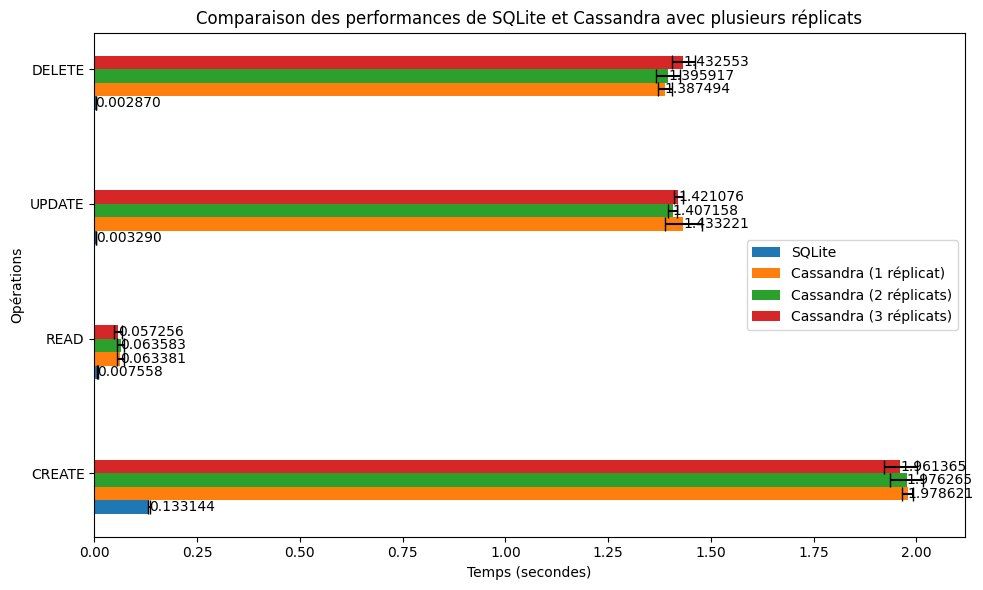

In [36]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean, create_sqlite_massive_std),
    'READ': (read_sqlite_massive_mean, read_sqlite_massive_std),
    'UPDATE': (update_sqlite_massive_mean, update_sqlite_massive_std),
    'DELETE': (delete_sqlite_massive_mean, delete_sqlite_massive_std)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cassandra_massive_mean, create_cassandra_massive_std),
    'READ': (read_cassandra_massive_mean, read_cassandra_massive_std),
    'UPDATE': (update_cassandra_massive_mean, update_cassandra_massive_std),
    'DELETE': (delete_cassandra_massive_mean, delete_cassandra_massive_std)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_2, create_cassandra_massive_std_2),
    'READ': (read_cassandra_massive_mean_2, read_cassandra_massive_std_2),
    'UPDATE': (update_cassandra_massive_mean_2, update_cassandra_massive_std_2),
    'DELETE': (delete_cassandra_massive_mean_2, delete_cassandra_massive_std_2)
}

cassandra_times_3 = {
    'CREATE': (create_cassandra_massive_mean_3, create_cassandra_massive_std_3),
    'READ': (read_cassandra_massive_mean_3, read_cassandra_massive_std_3),
    'UPDATE': (update_cassandra_massive_mean_3, update_cassandra_massive_std_3),
    'DELETE': (delete_cassandra_massive_mean_3, delete_cassandra_massive_std_3)
}

# cassandra_times_4 = {
#     'CREATE': (create_cassandra_massive_mean_4, create_cassandra_massive_std_4),
#     'READ': (read_cassandra_massive_mean_4, read_cassandra_massive_std_4),
#     'UPDATE': (update_cassandra_massive_mean_4, update_cassandra_massive_std_4),
#     'DELETE': (delete_cassandra_massive_mean_4, delete_cassandra_massive_std_4)
# }

# cassandra_times_5 = {
#     'CREATE': (create_cassandra_massive_mean_5, create_cassandra_massive_std_5),
#     'READ': (read_cassandra_massive_mean_5, read_cassandra_massive_std_5),
#     'UPDATE': (update_cassandra_massive_mean_5, update_cassandra_massive_std_5),
#     'DELETE': (delete_cassandra_massive_mean_5, delete_cassandra_massive_std_5)
# }

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les temps moyens et écarts-types pour chaque système
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_3 = [cassandra_times_3[op][0] for op in operations]
cassandra_stds_3 = [cassandra_times_3[op][1] for op in operations]

# cassandra_means_4 = [cassandra_times_4[op][0] for op in operations]
# cassandra_stds_4 = [cassandra_times_4[op][1] for op in operations]

# cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
# cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.1
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - 2.5 * height, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5)
bars2 = ax.barh(y - 1.5 * height, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5)
bars3 = ax.barh(y - 0.5 * height, cassandra_means_2, height, xerr=cassandra_stds_2, label='Cassandra (2 réplicats)', capsize=5)
bars4 = ax.barh(y + 0.5 * height, cassandra_means_3, height, xerr=cassandra_stds_2, label='Cassandra (3 réplicats)', capsize=5)
# bars5 = ax.barh(y + 1.5 * height, cassandra_means_4, height, xerr=cassandra_stds_2, label='Cassandra (4 réplicats)', capsize=5)
# bars6 = ax.barh(y + 2.5 * height, cassandra_means_5, height, xerr=cassandra_stds_2, label='Cassandra (5 réplicats)', capsize=5)

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec plusieurs réplicats')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)
# add_values(bars5)
# add_values(bars6)

plt.tight_layout()
plt.show()

TODO commenter 

expliquer les temps : 

Pourquoi essayer plusieurs niveaux de réplication ?
Impact sur les performances des lectures : Plus vous avez de répliques, plus Cassandra doit examiner plusieurs nœuds pour répondre à une requête de lecture. Cela peut augmenter la latence en fonction du niveau de réplication et de la manière dont les nœuds sont répartis.
Impact sur les écritures : En fonction de la configuration de réplication, chaque écriture doit être propagée vers plusieurs nœuds. Cela peut augmenter le temps d'insertion ou d'update, surtout en cas de faible cohérence (si un niveau de cohérence faible est choisi).
Tolérance aux pannes : Un nombre plus élevé de répliques permet à Cassandra de maintenir la disponibilité même en cas de panne de certains nœuds. Cependant, cela peut aussi introduire des coûts en termes de latence et de consommation de ressources.

TODO on peut essayer par la suite pas avec 1 2 3 mais genre 1 5 10 ?

# Création d'un dataset plus grand

Utiliser une base de données plus grande : Cassandra est mieux adapté pour gérer de grandes quantités de données et pour tirer parti de son architecture distribuée.
On va donc augmenter notre jeu de données 

On crée nous même ce dataset car les sites de création de dataset ne permettent de télécharger que 1000 lignes avec un compte gratuit.

In [37]:
df_initial.shape

(8807, 12)

In [ ]:
# Activer ou désactiver la génération de données supplémentaires
more_data = True

if more_data:
    # Charger le dataset initial
    original_df = df_initial  # Remplace par ton DataFrame de départ

    # Nombre total de lignes souhaitées
    num_rows = 30000

    # Fonction pour générer des colonnes supplémentaires à partir de données existantes
    def generate_large_column(original_column, size):
        return [random.choice(original_column) for _ in range(size)]

    # Fonction pour générer des IDs uniques
    def generate_unique_show_id(existing_ids, size):
        start_id = max(existing_ids) + 1 if existing_ids else 1
        return [f"{i}" for i in range(start_id, start_id + size)]

    # Générer les données pour chaque colonne
    generated_data = original_df.to_dict(orient='list')  # Convertir en dictionnaire de colonnes

    # Assurer l'unicité des IDs
    existing_ids = set(map(int, original_df["show_id"].tolist()))  # Obtenir les IDs existants
    new_ids = generate_unique_show_id(existing_ids, num_rows - len(original_df))
    generated_data["show_id"].extend(new_ids)

    # Générer les autres colonnes
    for column in original_df.columns:
        if column != "show_id":  # Ne pas regénérer la colonne show_id
            generated_data[column].extend(generate_large_column(original_df[column].tolist(), num_rows - len(original_df)))

    # Créer un DataFrame à partir des données générées
    large_df = pd.DataFrame(generated_data)

    # Supprimer les doublons éventuels (vérifie toutes les colonnes)
    large_df = large_df.drop_duplicates()

    # Remplacer les NaN explicitement pour chaque colonne
    for column in large_df.columns:
        if large_df[column].isnull().any():
            if large_df[column].dtype == "object":
                large_df[column].fillna("Unknown", inplace=True)  # Texte : remplacer par 'Unknown'
            else:
                large_df[column].fillna(0, inplace=True)  # Numérique : remplacer par 0

    # Supprimer les doublons éventuels (vérifie toutes les colonnes)
    large_df = large_df.drop_duplicates()

    # Vérifie qu'il n'y a pas de doublons dans 'show_id'
    if large_df["show_id"].duplicated().any():
        print("Attention : Des doublons existent dans la colonne 'show_id'.")
    else:
        print("Les IDs sont uniques.")

    # Sauvegarder le dataset dans un fichier CSV
    output_file = "netflix_titles_large.csv"
    large_df.to_csv(output_file, index=False)
    print(f"Dataset généré avec {len(large_df)} lignes (lignes dupliquées supprimées) et exporté dans {output_file}.")


Les IDs sont uniques.
Dataset généré avec 30000 lignes (lignes dupliquées supprimées) et exporté dans netflix_titles_large.csv.


In [39]:
large_df.shape

(30000, 12)

In [40]:
# Caster correctement les colonnes 
large_df['show_id'] = large_df['show_id'].astype(int)

large_df['show_id'] = large_df['show_id'].astype(int)
large_df['release_year'] = large_df['release_year'].astype(int)

large_df['type'] = large_df['title'].astype(str)
large_df['title'] = large_df['title'].astype(str)
large_df['director'] = large_df['director'].astype(str)
large_df['cast'] = large_df['cast'].astype(str)
large_df['country'] = large_df['country'].astype(str)
large_df['date_added'] = large_df['date_added'].astype(str)
large_df['rating'] = large_df['rating'].astype(str)
large_df['duration'] = large_df['duration'].astype(str)
large_df['listed_in'] = large_df['listed_in'].astype(str)
large_df['description'] = large_df['description'].astype(str)

In [41]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean, create_sqlite_massive_std = benchmark_operation(sqlite_insert, large_df)
print(f"CREATE: Mean Time = {create_sqlite_massive_mean:.6f}s, Std Time = {create_sqlite_massive_std:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_sqlite_massive_mean, read_sqlite_massive_std = benchmark_operation(sqlite_read, large_df)
print(f"READ: Mean Time = {read_sqlite_massive_mean:.6f}s, Std Time = {read_sqlite_massive_std:.6f}s")

# --- UPDATE ---
update_sqlite_massive_mean, update_sqlite_massive_std = benchmark_operation(sqlite_update, large_df)
print(f"UPDATE: Mean Time = {update_sqlite_massive_mean:.6f}s, Std Time = {update_sqlite_massive_std:.6f}s")

# --- DELETE ---
delete_sqlite_massive_mean, delete_sqlite_massive_std = benchmark_operation(sqlite_delete, large_df)
print(f"DELETE: Mean Time = {delete_sqlite_massive_mean:.6f}s, Std Time = {delete_sqlite_massive_std:.6f}s")

Create Time: 0.465658 seconds
Create Time: 0.467382 seconds
Create Time: 0.465722 seconds
Create Time: 0.461695 seconds
Create Time: 0.467449 seconds
CREATE: Mean Time = 0.465581s, Std Time = 0.002091s
Total rows in 'shows' table: 30000
Create Time: 0.460702 seconds
Read Time: 0.029445 seconds
Queried 28163 records
Create Time: 0.464639 seconds
Read Time: 0.028573 seconds
Queried 28163 records
Create Time: 0.468247 seconds
Read Time: 0.027431 seconds
Queried 28163 records
Create Time: 0.460076 seconds
Read Time: 0.027560 seconds
Queried 28163 records
Create Time: 0.448781 seconds
Read Time: 0.027255 seconds
Queried 28163 records
READ: Mean Time = 0.028053s, Std Time = 0.000834s
Create Time: 0.450072 seconds
Update Time: 0.013227 seconds
Create Time: 0.459809 seconds
Update Time: 0.013155 seconds
Create Time: 0.462498 seconds
Update Time: 0.012814 seconds
Create Time: 0.450241 seconds
Update Time: 0.012963 seconds
Create Time: 0.461429 seconds
Update Time: 0.012851 seconds
UPDATE: Mean 

In [42]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_mean, create_cassandra_std = benchmark_operation(cassandra_insert, large_df, 1)
print(f"CREATE: Mean Time = {create_cassandra_mean:.6f}s, Std Time = {create_cassandra_std:.6f}s")

# Vérifier le nombre de lignes insérées
result = session.execute('SELECT COUNT(*) FROM shows')
row = result.one()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_mean, read_cassandra_std = benchmark_operation(cassandra_read, large_df, 1)
print(f"READ: Mean Time = {read_cassandra_mean:.6f}s, Std Time = {read_cassandra_std:.6f}s")

# --- UPDATE ---
update_cassandra_mean, update_cassandra_std = benchmark_operation(cassandra_update, large_df, 1)
print(f"UPDATE: Mean Time = {update_cassandra_mean:.6f}s, Std Time = {update_cassandra_std:.6f}s")

# --- DELETE ---
delete_cassandra_mean, delete_cassandra_std = benchmark_operation(cassandra_delete, large_df, 1)
print(f"DELETE: Mean Time = {delete_cassandra_mean:.6f}s, Std Time = {delete_cassandra_std:.6f}s")


replication factor = 1
Create Time: 6.788272 seconds
replication factor = 1
Create Time: 6.821386 seconds
replication factor = 1
Create Time: 6.767228 seconds
replication factor = 1
Create Time: 6.772167 seconds
replication factor = 1
Create Time: 6.783371 seconds
CREATE: Mean Time = 6.786485s, Std Time = 0.019009s
Total rows in 'shows' table: 30000
replication factor = 1
Create Time: 6.726884 seconds
Read Time: 0.058399 seconds
Queried 28163 records
replication factor = 1
Create Time: 6.751205 seconds
Read Time: 0.058209 seconds
Queried 28163 records
replication factor = 1
Create Time: 6.771187 seconds
Read Time: 0.058125 seconds
Queried 28163 records
replication factor = 1
Create Time: 6.771632 seconds
Read Time: 0.083875 seconds
Queried 28163 records
replication factor = 1
Create Time: 6.849478 seconds
Read Time: 0.057865 seconds
Queried 28163 records
READ: Mean Time = 0.063295s, Std Time = 0.010292s
replication factor = 1
Create Time: 6.765383 seconds
Update Time: 4.826262 seconds


In [43]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_2, create_cassandra_massive_std_2 = benchmark_operation(cassandra_insert, large_df, 2)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean_2:.6f}s, Std Time = {create_cassandra_massive_std_2:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_massive_mean_2, read_cassandra_massive_std_2 = benchmark_operation(cassandra_read, large_df, 2)
print(f"READ: Mean Time = {read_cassandra_massive_mean_2:.6f}s, Std Time = {read_cassandra_massive_std_2:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean_2, update_cassandra_massive_std_2 = benchmark_operation(cassandra_update, large_df, 2)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_2:.6f}s, Std Time = {update_cassandra_massive_std_2:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean_2, delete_cassandra_massive_std_2 = benchmark_operation(cassandra_delete, large_df, 2)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_2:.6f}s, Std Time = {delete_cassandra_massive_std_2:.6f}s")


replication factor = 2
Create Time: 6.628602 seconds
replication factor = 2
Create Time: 6.977443 seconds
replication factor = 2
Create Time: 6.991718 seconds
replication factor = 2
Create Time: 7.121857 seconds
replication factor = 2
Create Time: 6.890444 seconds
CREATE: Mean Time = 6.922013s, Std Time = 0.164290s
Total rows in 'shows' table: 1837
replication factor = 2
Create Time: 6.840382 seconds
Read Time: 0.073904 seconds
Queried 28163 records
replication factor = 2
Create Time: 6.840843 seconds
Read Time: 0.060405 seconds
Queried 28163 records
replication factor = 2
Create Time: 6.954779 seconds
Read Time: 0.058691 seconds
Queried 28163 records
replication factor = 2
Create Time: 6.649458 seconds
Read Time: 0.083170 seconds
Queried 28163 records
replication factor = 2
Create Time: 6.670960 seconds
Read Time: 0.059011 seconds
Queried 28163 records
READ: Mean Time = 0.067036s, Std Time = 0.009854s
replication factor = 2
Create Time: 6.932253 seconds
Update Time: 4.925218 seconds
r

In [44]:
# 3 replicas
# --- CREATE ---
create_cassandra_massive_mean_3, create_cassandra_massive_std_3 = benchmark_operation(cassandra_insert, large_df, 3)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean_3:.6f}s, Std Time = {create_cassandra_massive_std_3:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_massive_mean_3, read_cassandra_massive_std_3 = benchmark_operation(cassandra_read, large_df, 3)
print(f"READ: Mean Time = {read_cassandra_massive_mean_3:.6f}s, Std Time = {read_cassandra_massive_std_3:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean_3, update_cassandra_massive_std_3 = benchmark_operation(cassandra_update, large_df, 3)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_3:.6f}s, Std Time = {update_cassandra_massive_std_3:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean_3, delete_cassandra_massive_std_3 = benchmark_operation(cassandra_delete, large_df, 3)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_3:.6f}s, Std Time = {delete_cassandra_massive_std_3:.6f}s")



replication factor = 3
Create Time: 6.581456 seconds
replication factor = 3
Create Time: 6.600733 seconds
replication factor = 3
Create Time: 6.598071 seconds
replication factor = 3
Create Time: 6.685602 seconds
replication factor = 3
Create Time: 6.649437 seconds
CREATE: Mean Time = 6.623060s, Std Time = 0.038629s
Total rows in 'shows' table: 1837
replication factor = 3
Create Time: 6.589636 seconds
Read Time: 0.058138 seconds
Queried 28163 records
replication factor = 3
Create Time: 6.594204 seconds
Read Time: 0.057449 seconds
Queried 28163 records
replication factor = 3
Create Time: 6.792741 seconds
Read Time: 0.058968 seconds
Queried 28163 records
replication factor = 3
Create Time: 6.921719 seconds
Read Time: 0.058809 seconds
Queried 28163 records
replication factor = 3
Create Time: 7.044128 seconds
Read Time: 0.058986 seconds
Queried 28163 records
READ: Mean Time = 0.058470s, Std Time = 0.000597s
replication factor = 3
Create Time: 7.059959 seconds
Update Time: 5.024749 seconds
r

In [45]:

# # 4 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_4, create_cassandra_massive_std_4 = benchmark_operation(cassandra_insert, large_df, 4)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_4:.6f}s, Std Time = {create_cassandra_massive_std_4:.6f}s")

# # Vérifier le nombre de lignes insérées
# cursor.execute('SELECT COUNT(*) FROM shows')
# row = cursor.fetchone()
# print(f"Total rows in 'shows' table: {row[0]}")

# # --- READ ---
# read_cassandra_massive_mean_4, read_cassandra_massive_std_4 = benchmark_operation(cassandra_read, large_df, 4)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_4:.6f}s, Std Time = {read_cassandra_massive_std_4:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_4, update_cassandra_massive_std_4 = benchmark_operation(cassandra_update, large_df, 4)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_4:.6f}s, Std Time = {update_cassandra_massive_std_4:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_4, delete_cassandra_massive_std_4 = benchmark_operation(cassandra_delete, large_df, 4)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_4:.6f}s, Std Time = {delete_cassandra_massive_std_4:.6f}s")

# # 5 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_5, create_cassandra_massive_std_5 = benchmark_operation(cassandra_insert, large_df, 5)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_5:.6f}s, Std Time = {create_cassandra_massive_std_5:.6f}s")

# # Vérifier le nombre de lignes insérées
# cursor.execute('SELECT COUNT(*) FROM shows')
# row = cursor.fetchone()
# print(f"Total rows in 'shows' table: {row[0]}")

# # --- READ ---
# read_cassandra_massive_mean_5, read_cassandra_massive_std_5 = benchmark_operation(cassandra_read, large_df, 5)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_5:.6f}s, Std Time = {read_cassandra_massive_std_5:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_5, update_cassandra_massive_std_5 = benchmark_operation(cassandra_update, large_df, 5)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_5:.6f}s, Std Time = {update_cassandra_massive_std_5:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_5, delete_cassandra_massive_std_5 = benchmark_operation(cassandra_delete, large_df, 5)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_5:.6f}s, Std Time = {delete_cassandra_massive_std_5:.6f}s")

## Visualisation

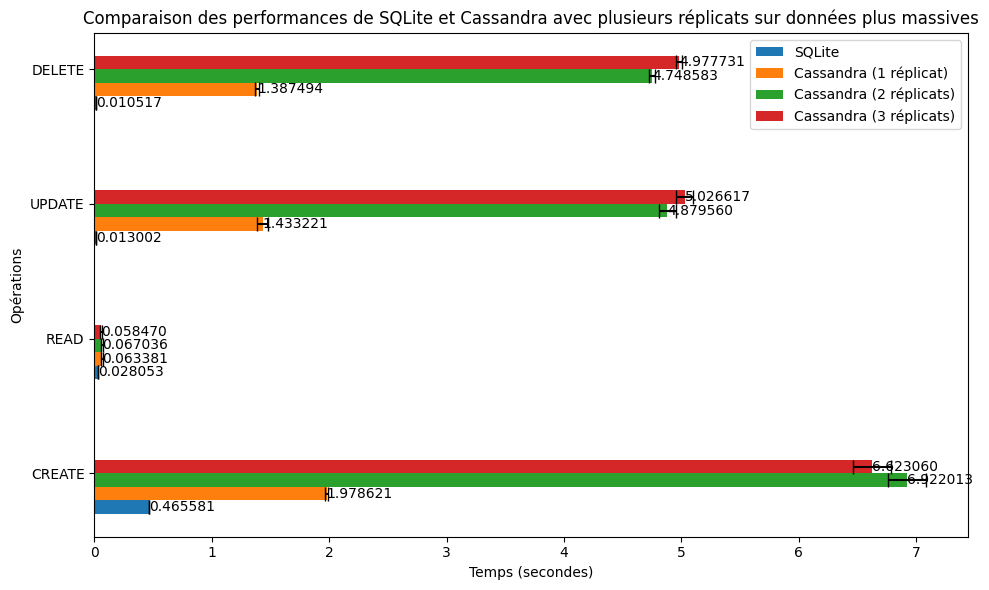

In [46]:
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean, create_sqlite_massive_std),
    'READ': (read_sqlite_massive_mean, read_sqlite_massive_std),
    'UPDATE': (update_sqlite_massive_mean, update_sqlite_massive_std),
    'DELETE': (delete_sqlite_massive_mean, delete_sqlite_massive_std)
}

cassandra_times = {
    'CREATE': (create_cassandra_massive_mean, create_cassandra_massive_std),
    'READ': (read_cassandra_massive_mean, read_cassandra_massive_std),
    'UPDATE': (update_cassandra_massive_mean, update_cassandra_massive_std),
    'DELETE': (delete_cassandra_massive_mean, delete_cassandra_massive_std)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_2, create_cassandra_massive_std_2),
    'READ': (read_cassandra_massive_mean_2, read_cassandra_massive_std_2),
    'UPDATE': (update_cassandra_massive_mean_2, update_cassandra_massive_std_2),
    'DELETE': (delete_cassandra_massive_mean_2, delete_cassandra_massive_std_2)
}

cassandra_times_3 = {
    'CREATE': (create_cassandra_massive_mean_3, create_cassandra_massive_std_3),
    'READ': (read_cassandra_massive_mean_3, read_cassandra_massive_std_3),
    'UPDATE': (update_cassandra_massive_mean_3, update_cassandra_massive_std_3),
    'DELETE': (delete_cassandra_massive_mean_3, delete_cassandra_massive_std_3)
}

# cassandra_times_4 = {
#     'CREATE': (create_cassandra_massive_mean_4, create_cassandra_massive_std_4),
#     'READ': (read_cassandra_massive_mean_4, read_cassandra_massive_std_4),
#     'UPDATE': (update_cassandra_massive_mean_4, update_cassandra_massive_std_4),
#     'DELETE': (delete_cassandra_massive_mean_4, delete_cassandra_massive_std_4)
# }

# cassandra_times_5 = {
#     'CREATE': (create_cassandra_massive_mean_5, create_cassandra_massive_std_5),
#     'READ': (read_cassandra_massive_mean_5, read_cassandra_massive_std_5),
#     'UPDATE': (update_cassandra_massive_mean_5, update_cassandra_massive_std_5),
#     'DELETE': (delete_cassandra_massive_mean_5, delete_cassandra_massive_std_5)
# }

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les temps moyens et écarts-types pour chaque système
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_3 = [cassandra_times_3[op][0] for op in operations]
cassandra_stds_3 = [cassandra_times_3[op][1] for op in operations]

# cassandra_means_4 = [cassandra_times_4[op][0] for op in operations]
# cassandra_stds_4 = [cassandra_times_4[op][1] for op in operations]

# cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
# cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.1
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - 2.5 * height, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5)
bars2 = ax.barh(y - 1.5 * height, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5)
bars3 = ax.barh(y - 0.5 * height, cassandra_means_2, height, xerr=cassandra_stds_2, label='Cassandra (2 réplicats)', capsize=5)
bars4 = ax.barh(y + 0.5 * height, cassandra_means_3, height, xerr=cassandra_stds_2, label='Cassandra (3 réplicats)', capsize=5)
# bars5 = ax.barh(y + 1.5 * height, cassandra_means_4, height, xerr=cassandra_stds_2, label='Cassandra (4 réplicats)', capsize=5)
# bars6 = ax.barh(y + 2.5 * height, cassandra_means_5, height, xerr=cassandra_stds_2, label='Cassandra (5 réplicats)', capsize=5)

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec plusieurs réplicats sur données plus massives')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)
# add_values(bars5)
# add_values(bars6)

plt.tight_layout()
plt.show()

TODO commenter la visualisation aussi 

On voit bien que 1 replica Set bien plus rapide que plus : y a déjà un commentaire là dessus en haut

# Comparaison avec / sans index

### Index secondaires (clés secondaires)


Dans Cassandra, la commande `CREATE INDEX` permet de créer des index secondaires, qui ne sont pas des clés primaires. Cela permet de filtrer les données sur des colonnes autres que la partition key ou les clustering keys.

#### Avantages des index secondaires

- Facilite les filtres sur des colonnes non clés : Vous pouvez filtrer sur des colonnes autres que la partition key ou les clustering keys, ce qui rend les requêtes plus flexibles.
- Accès plus rapide aux données : Les index secondaires optimisent les requêtes qui filtrent sur certaines colonnes spécifiques, réduisant le nombre de partitions à examiner.

#### Inconvénients des index secondaires

- Risque de surcharge de performance : Sur de grandes tables, si une colonne contient beaucoup de valeurs distinctes, l'index peut devenir lourd et ralentir les performances des écritures et lectures.
- Structure distribuée moins efficace : Les index secondaires sont distribués, mais leur gestion est moins performante que les clés primaires, surtout sur des colonnes avec une haute cardinalité.
- Limitations d'usage : Les index secondaires sont mieux utilisés sur des colonnes avec faible cardinalité. Il est déconseillé de les utiliser pour des colonnes ayant une forte cardinalité ou pour des filtres complexes impliquant plusieurs colonnes.
- `ALLOW FILTERING` : Parfois, pour exécuter une requête avec un index secondaire, vous devrez utiliser `ALLOW FILTERING`, ce qui peut nuire aux performances en scannant une grande partie des données.

In [47]:
def cassandra_create_indexes(columns):
    start_time = time.time()
    for column in columns:
        index_query = f"CREATE INDEX {column}_idx ON shows ({column});"
        session.execute(index_query)
    cassandra_time = time.time() - start_time
    return cassandra_time


def sqlite_create_indexes(columns):
    # drop les index
    for column in columns:
        index_query = f"DROP INDEX IF EXISTS {column}_idx;"
        cursor.execute(index_query)

    start_time = time.time()
    for column in columns:
        # Créer une requête SQL pour chaque colonne
        index_query = f"CREATE INDEX IF NOT EXISTS {column}_idx ON shows ({column});"
        cursor.execute(index_query)
    sqlite_time = time.time() - start_time
    return sqlite_time

columns_to_index = ["release_year"]
cassandra_time_index = cassandra_create_indexes(columns_to_index)
sqlite_time_index = sqlite_create_indexes(columns_to_index)

print(f"Indexation time: Cassandra {cassandra_time_index:.5f}s, SQLite {sqlite_time_index:.5f}s")

Indexation time: Cassandra 0.08488s, SQLite 0.00122s


In [48]:
# Fonctions pour CRUD SQLite avec index

# --- CREATE ---
def sqlite_insert_index(df):
    drop_table_sqlite()
    create_table_sqlite()
    sqlite_create_indexes(columns_to_index)

    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    return create_time_sqlite

# --- READ ---
def sqlite_read_index(df):
    sqlite_insert_index(df)
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year > 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    return read_time_sqlite

# --- UPDATE ---
def sqlite_update_index(df):
    sqlite_insert_index(df)
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year > 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    return update_time_sqlite

# --- DELETE ---
def sqlite_delete_index(df):
    sqlite_insert_index(df)
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year > 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    return delete_time_sqlite

In [49]:
# Fonctions pour CRUD Cassandra avec index
# --- CREATE ---
def cassandra_insert_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)
    cassandra_create_indexes(columns_to_index)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time

    print(f"Create Time: {create_time:.6f} seconds")

    return create_time


# --- READ ---
def cassandra_read_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    # allow filtering car clef secondaire, pas primaire 
    start_time = time.time()
    result = session.execute('SELECT * FROM shows WHERE release_year > 2000 ALLOW FILTERING ;')
    read_time = time.time() - start_time
    print(f"Read time with index: {read_time:.5f}s")
    num_records = sum(1 for _ in result)
    print(f"Number of records: {num_records}")
    return read_time 


# --- UPDATE ---
def cassandra_update_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    start_time = time.time()
    update_query = "UPDATE shows SET rating = 'PG' WHERE release_year > 2000;"
    session.execute(update_query)
    update_time = time.time() - start_time
    print(f"Update time with index: {update_time:.5f}s")
    return update_time


# --- DELETE ---
def cassandra_delete_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    start_time = time.time()
    delete_query = "DELETE FROM shows WHERE release_year > 2000;"
    session.execute(delete_query)
    delete_time = time.time() - start_time
    print(f"Delete time with index: {delete_time:.5f}s")
    return delete_time

In [50]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean_index, create_sqlite_massive_std_index = benchmark_operation(sqlite_insert_index, large_df)
print(f"CREATE: Mean Time = {create_sqlite_massive_mean_index:.6f}s, Std Time = {create_sqlite_massive_std_index:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_sqlite_massive_mean_index, read_sqlite_massive_std_index = benchmark_operation(sqlite_read_index, large_df)
print(f"READ: Mean Time = {read_sqlite_massive_mean_index:.6f}s, Std Time = {read_sqlite_massive_std_index:.6f}s")

# --- UPDATE ---
update_sqlite_massive_mean_index, update_sqlite_massive_std_index = benchmark_operation(sqlite_update_index, large_df)
print(f"UPDATE: Mean Time = {update_sqlite_massive_mean_index:.6f}s, Std Time = {update_sqlite_massive_std_index:.6f}s")

# --- DELETE ---
delete_sqlite_massive_mean_index, delete_sqlite_massive_std_index = benchmark_operation(sqlite_delete_index, large_df)
print(f"DELETE: Mean Time = {delete_sqlite_massive_mean_index:.6f}s, Std Time = {delete_sqlite_massive_std_index:.6f}s")

Create Time: 0.499491 seconds
Create Time: 0.471748 seconds
Create Time: 0.481601 seconds
Create Time: 0.507249 seconds
Create Time: 0.476642 seconds
CREATE: Mean Time = 0.487346s, Std Time = 0.013671s
Total rows in 'shows' table: 30000
Create Time: 0.472596 seconds
Read Time: 0.036770 seconds
Queried 28163 records
Create Time: 0.476527 seconds
Read Time: 0.039507 seconds
Queried 28163 records
Create Time: 0.469644 seconds
Read Time: 0.034857 seconds
Queried 28163 records
Create Time: 0.476826 seconds
Read Time: 0.034612 seconds
Queried 28163 records
Create Time: 0.475771 seconds
Read Time: 0.034531 seconds
Queried 28163 records
READ: Mean Time = 0.036055s, Std Time = 0.001911s
Create Time: 0.508565 seconds
Update Time: 0.020337 seconds
Create Time: 0.475619 seconds
Update Time: 0.019197 seconds
Create Time: 0.476921 seconds
Update Time: 0.018948 seconds
Create Time: 0.478930 seconds
Update Time: 0.019244 seconds
Create Time: 0.475814 seconds
Update Time: 0.018621 seconds
UPDATE: Mean 

In [51]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_mean_index, create_cassandra_std_index = benchmark_operation(cassandra_insert_index, large_df, 1)
print(f"CREATE: Mean Time = {create_cassandra_mean_index:.6f}s, Std Time = {create_cassandra_std_index:.6f}s")

# --- READ ---
read_cassandra_mean_index, read_cassandra_std_index = benchmark_operation(cassandra_read_index, large_df, 1)
print(f"READ: Mean Time = {read_cassandra_mean_index:.6f}s, Std Time = {read_cassandra_std_index:.6f}s")

# --- UPDATE ---
update_cassandra_mean_index, update_cassandra_std_index = benchmark_operation(cassandra_update_index, large_df, 1)
print(f"UPDATE: Mean Time = {update_cassandra_mean_index:.6f}s, Std Time = {update_cassandra_std_index:.6f}s")

# --- DELETE ---
delete_cassandra_mean_index, delete_cassandra_std_index = benchmark_operation(cassandra_delete_index, large_df, 1)
print(f"DELETE: Mean Time = {delete_cassandra_mean_index:.6f}s, Std Time = {delete_cassandra_std_index:.6f}s")

# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_2_index, create_cassandra_massive_std_2_index = benchmark_operation(cassandra_insert_index, large_df, 2)
print(f"CREATE: Mean Time = {create_cassandra_massive_mean_2_index:.6f}s, Std Time = {create_cassandra_massive_std_2_index:.6f}s")

# Vérifier le nombre de lignes insérées
cursor.execute('SELECT COUNT(*) FROM shows')
row = cursor.fetchone()
print(f"Total rows in 'shows' table: {row[0]}")

# --- READ ---
read_cassandra_massive_mean_2_index, read_cassandra_massive_std_2_index = benchmark_operation(cassandra_read_index, large_df, 2)
print(f"READ: Mean Time = {read_cassandra_massive_mean_2_index:.6f}s, Std Time = {read_cassandra_massive_std_2_index:.6f}s")

# --- UPDATE ---
update_cassandra_massive_mean_2_index, update_cassandra_massive_std_2_index = benchmark_operation(cassandra_update_index, large_df, 2)
print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_2_index:.6f}s, Std Time = {update_cassandra_massive_std_2_index:.6f}s")

# --- DELETE ---
delete_cassandra_massive_mean_2_index, delete_cassandra_massive_std_2_index = benchmark_operation(cassandra_delete_index, large_df, 2)
print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_2_index:.6f}s, Std Time = {delete_cassandra_massive_std_2_index:.6f}s")

# # 3 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_3_index, create_cassandra_massive_std_3_index = benchmark_operation(cassandra_insert_index, large_df, 3)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_3_index:.6f}s, Std Time = {create_cassandra_massive_std_3_index:.6f}s")

# # Vérifier le nombre de lignes insérées
# cursor.execute('SELECT COUNT(*) FROM shows')
# row = cursor.fetchone()
# print(f"Total rows in 'shows' table: {row[0]}")

# # --- READ ---
# read_cassandra_massive_mean_3_index, read_cassandra_massive_std_3_index = benchmark_operation(cassandra_read_index, large_df, 3)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_3_index:.6f}s, Std Time = {read_cassandra_massive_std_3_index:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_3_index, update_cassandra_massive_std_3_index = benchmark_operation(cassandra_update_index, large_df, 3)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_3_index:.6f}s, Std Time = {update_cassandra_massive_std_3_index:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_3_index, delete_cassandra_massive_std_3_index = benchmark_operation(cassandra_delete_index, large_df, 3)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_3_index:.6f}s, Std Time = {delete_cassandra_massive_std_3_index:.6f}s")


# # 4 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_4_index, create_cassandra_massive_std_4_index = benchmark_operation(cassandra_insert_index, large_df, 4)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_4_index:.6f}s, Std Time = {create_cassandra_massive_std_4_index:.6f}s")

# # Vérifier le nombre de lignes insérées
# cursor.execute('SELECT COUNT(*) FROM shows')
# row = cursor.fetchone()
# print(f"Total rows in 'shows' table: {row[0]}")

# # --- READ ---
# read_cassandra_massive_mean_4_index, read_cassandra_massive_std_4_index = benchmark_operation(cassandra_read_index, large_df, 4)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_4_index:.6f}s, Std Time = {read_cassandra_massive_std_4_index:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_4_index, update_cassandra_massive_std_4_index = benchmark_operation(cassandra_update_index, large_df, 4)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_4_index:.6f}s, Std Time = {update_cassandra_massive_std_4_index:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_4_index, delete_cassandra_massive_std_4_index = benchmark_operation(cassandra_delete_index, large_df, 4)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_4_index:.6f}s, Std Time = {delete_cassandra_massive_std_4_index:.6f}s")

# # 5 replicas
# # --- CREATE ---
# create_cassandra_massive_mean_5_index, create_cassandra_massive_std_5_index = benchmark_operation(cassandra_insert_index, large_df, 5)
# print(f"CREATE: Mean Time = {create_cassandra_massive_mean_5_index:.6f}s, Std Time = {create_cassandra_massive_std_5_index:.6f}s")

# # Vérifier le nombre de lignes insérées
# cursor.execute('SELECT COUNT(*) FROM shows')
# row = cursor.fetchone()
# print(f"Total rows in 'shows' table: {row[0]}")

# # --- READ ---
# read_cassandra_massive_mean_5_index, read_cassandra_massive_std_5_index = benchmark_operation(cassandra_read_index, large_df, 5)
# print(f"READ: Mean Time = {read_cassandra_massive_mean_5_index:.6f}s, Std Time = {read_cassandra_massive_std_5_index:.6f}s")

# # --- UPDATE ---
# update_cassandra_massive_mean_5_index, update_cassandra_massive_std_5_index = benchmark_operation(cassandra_update_index, large_df, 5)
# print(f"UPDATE: Mean Time = {update_cassandra_massive_mean_5_index:.6f}s, Std Time = {update_cassandra_massive_std_5_index:.6f}s")

# # --- DELETE ---
# delete_cassandra_massive_mean_5_index, delete_cassandra_massive_std_5_index = benchmark_operation(cassandra_delete_index, large_df, 5)
# print(f"DELETE: Mean Time = {delete_cassandra_massive_mean_5_index:.6f}s, Std Time = {delete_cassandra_massive_std_5_index:.6f}s")

replication factor = 1
Create Time: 7.083335 seconds
replication factor = 1
Create Time: 6.901984 seconds
replication factor = 1
Create Time: 7.011228 seconds
replication factor = 1
Create Time: 7.010921 seconds
replication factor = 1
Create Time: 7.223150 seconds
CREATE: Mean Time = 7.046124s, Std Time = 0.105789s
replication factor = 1
Create Time: 7.069833 seconds
Read time with index: 0.06036s
Number of records: 28163
replication factor = 1
Create Time: 7.053473 seconds
Read time with index: 0.05990s
Number of records: 28163
replication factor = 1
Create Time: 7.206771 seconds
Read time with index: 0.05910s
Number of records: 28163
replication factor = 1
Create Time: 6.900431 seconds
Read time with index: 0.08840s
Number of records: 28163
replication factor = 1
Create Time: 6.905147 seconds
Read time with index: 0.06094s
Number of records: 28163
READ: Mean Time = 0.065739s, Std Time = 0.011348s
replication factor = 1
Create Time: 6.829198 seconds


InvalidRequest: Error from server: code=2200 [Invalid query] message="Some partition key parts are missing: show_id"

In [ ]:
# TODO : afficher différences temps avec et sans index pour chaque 

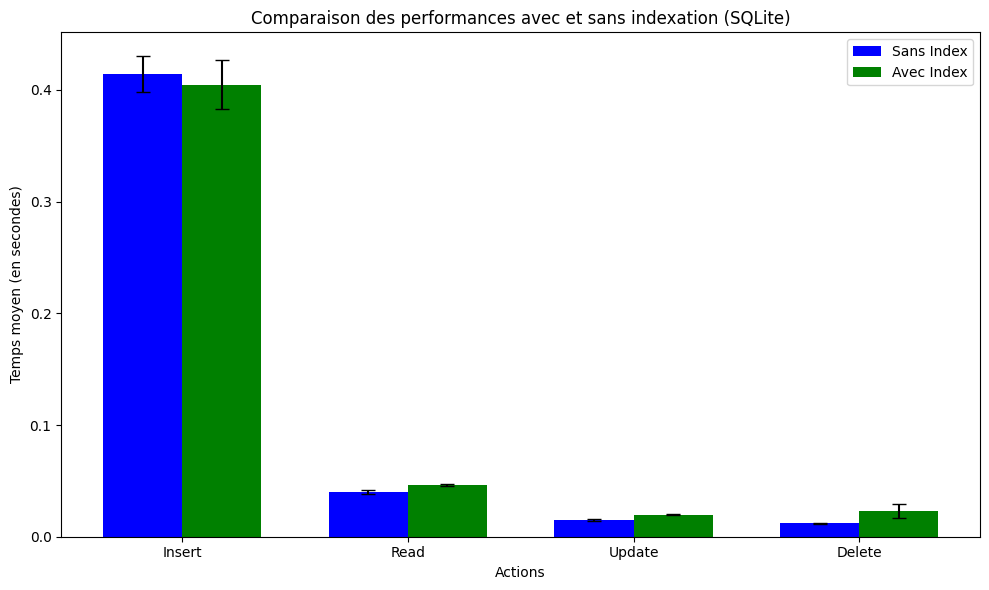

In [ ]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_sqlite_massive_mean, read_sqlite_massive_mean, 
                      update_sqlite_massive_mean, delete_sqlite_massive_mean]
mean_with_index = [create_sqlite_massive_mean_index, read_sqlite_massive_mean_index, 
                   update_sqlite_massive_mean_index, delete_sqlite_massive_mean_index]

std_without_index = [create_sqlite_massive_std, read_sqlite_massive_std, 
                     update_sqlite_massive_std, delete_sqlite_massive_std]
std_with_index = [create_sqlite_massive_std_index, read_sqlite_massive_std_index, 
                  update_sqlite_massive_std_index, delete_sqlite_massive_std_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, mean_without_index, width, yerr=std_without_index, label='Sans Index', color='b', capsize=5)
bars2 = ax.bar(x + width/2, mean_with_index, width, yerr=std_with_index, label='Avec Index', color='g', capsize=5)

ax.set_xlabel('Actions')
ax.set_ylabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (SQLite)')
ax.set_xticks(x)
ax.set_xticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_mean, read_cassandra_mean, 
                      update_cassandra_mean, delete_cassandra_mean]
mean_with_index = [create_cassandra_mean_index, read_cassandra_mean_index, 
                   update_cassandra_mean_index, delete_cassandra_mean_index]

std_without_index = [create_cassandra_std, read_cassandra_std, 
                     update_cassandra_std, delete_cassandra_std]
std_with_index = [create_cassandra_std_index, read_cassandra_std_index, 
                  update_cassandra_std_index, delete_cassandra_std_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, mean_without_index, width, yerr=std_without_index, label='Sans Index', color='b', capsize=5)
bars2 = ax.bar(x + width/2, mean_with_index, width, yerr=std_with_index, label='Avec Index', color='g', capsize=5)

ax.set_xlabel('Actions')
ax.set_ylabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (cassandra)')
ax.set_xticks(x)
ax.set_xticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_massive_mean_2, read_cassandra_massive_mean_2, 
                      update_cassandra_massive_mean_2, delete_cassandra_massive_mean_2]
mean_with_index = [create_cassandra_massive_mean_2_index, read_cassandra_massive_mean_2_index, 
                   update_cassandra_massive_mean_2_index, delete_cassandra_massive_mean_2_index]

std_without_index = [create_cassandra_massive_std_2, read_cassandra_massive_std_2, 
                     update_cassandra_massive_std_2, delete_cassandra_massive_std_2]
std_with_index = [create_cassandra_massive_std_2_index, read_cassandra_massive_std_2_index, 
                  update_cassandra_massive_std_2_index, delete_cassandra_massive_std_2_index]

x = np.arange(len(actions))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, mean_without_index, width, yerr=std_without_index, label='Sans Index', color='b', capsize=5)
bars2 = ax.bar(x + width/2, mean_with_index, width, yerr=std_with_index, label='Avec Index', color='g', capsize=5)

ax.set_xlabel('Actions')
ax.set_ylabel('Temps moyen (en secondes)')
ax.set_title('Comparaison des performances avec et sans indexation (cassandra)')
ax.set_xticks(x)
ax.set_xticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


NameError: name 'create_cassandra_massive_mean_2_index' is not defined

# ce qu'il reste 

# TODO INDEX sur PRIMARY 
# -> donc filtrer sur le show_id, avec et sans index 

# TODO CLUSTERING : Le clustering est une autre méthode de distribution des données dans Cassandra, mais cela se fait au sein d'une partition (c'est-à-dire que les données ayant la même clé de partition seront rangées ensemble en fonction de la clé de clustering). Le choix d'une bonne clé de clustering permet d’optimiser la lecture des données dans Cassandra.

# TODO : Effectuer des tests de charge : Augmenter le nombre de requêtes ou de transactions simultanées pour tester la scalabilité et la gestion des requêtes par Cassandra. Dans un scénario avec peu de données, SQLite peut sembler plus rapide, mais lorsque la charge augmente, Cassandra sera plus adapté pour gérer des performances à grande échelle

# TODO : BATCH c'est quoi ?
# TODO : REQUETES COMPLEXES
# TODO : JOINS
# TODO : REQUETES AVEC FILTRES

In [ ]:
# TODO Charlotte tu veux dire quoi ?
# Tester avec des requêtes plus complexes
# Utiliser un dataset plus grand (ça c'est au dessus)
#  Ajouter des colonnes à indexer (c'est fait aussi au dessus)
# Tous ces TODO n'ont rien changé.

# Fin du notebook

In [ ]:
# Tout fermer proprement
session.shutdown() # Fermer la connexion Cassandra
cluster.shutdown() # Fermer le cluster Cassandra
conn.close() # Fermer la connexion SQLite
cursor.close() # Fermer le curseur SQLite

In [ ]:
TODO vérifier plus de MySQL 